<a href="https://colab.research.google.com/github/sciencecw/AI4Code/blob/BERT/BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification using hugging face

In [ ]:
!nvidia-smi

Thu Jun  2 15:56:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade pip -q
!pip install -q ktrain

     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 46.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.7/263.7 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings, gc
warnings.filterwarnings("ignore")

# Tensorflow
import tensorflow as tf

# ktrain
import ktrain
from ktrain import text

# sklearn
from sklearn.model_selection import train_test_split

In [ ]:
%tensorflow_version 2.x
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.7065659940000018
GPU (s):
0.04036496500000908
GPU speedup over CPU: 17x


In [ ]:
df = pd.read_csv('finaldata_party.csv')
df.head()


,Unnamed: 0,speaker,text,type,election_year,date,candidate,result,party
0,0,John Kennedy,I uh – said that Ive served this country for f...,Pres,1960.0,1960-10-21,1.0,1,D
1,1,John Kennedy,"Mr. Howe, Mr. Vice President. First uh – let m...",Pres,1960.0,1960-10-21,1.0,1,D
2,2,Richard Nixon,"Mr. Howe, Senator Kennedy, my fellow Americans...",Pres,1960.0,1960-10-21,1.0,0,R
3,3,John Kennedy,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,1,D
4,4,Richard Nixon,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,0,R


In [ ]:
df.loc[df['party']=='D', 'party']=1
df.loc[df['party']=='R', 'party']=0
df = df[(df['party']==1)|(df['party']==0)]
df_tr = df[df.type.isin(['Pres','VP'])]
#df_tr = df_tr[df_tr.election_year > 2000]
df_tr.head()
#Democrats =1, Reps = 0

,Unnamed: 0,speaker,text,type,election_year,date,candidate,result,party
0,0,John Kennedy,I uh – said that Ive served this country for f...,Pres,1960.0,1960-10-21,1.0,1,1
1,1,John Kennedy,"Mr. Howe, Mr. Vice President. First uh – let m...",Pres,1960.0,1960-10-21,1.0,1,1
2,2,Richard Nixon,"Mr. Howe, Senator Kennedy, my fellow Americans...",Pres,1960.0,1960-10-21,1.0,0,0
3,3,John Kennedy,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,1,1
4,4,Richard Nixon,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,0,0


In [ ]:
target = ['party']
data = ['text']

X = df_tr[data]
y = df_tr[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.05, random_state=42)

In [ ]:
len(X_test)

262

In [ ]:
# Common Parameters
max_len = 300
batch_size = 32
learning_rate = 1e-3
epochs = 20


# With Roberta-base

In [ ]:
# Transformer Model
model_ = 'roberta-base'
t_mod = text.Transformer(model_, maxlen=max_len, classes = [0,1])


'''Converting split data to list [so it can processed]'''
#train
X_tr = X_train['text'].tolist()
y_tr = y_train['party'].tolist()

#test
X_ts = X_test['text'].tolist()
y_ts = y_test['party'].tolist()


# Pre-processing training & test data
train = t_mod.preprocess_train(X_tr,y_tr)
test = t_mod.preprocess_train(X_ts,y_ts)

# Model Classifier
model = t_mod.get_classifier()

learner = ktrain.get_learner(model, train_data=train, val_data=test, batch_size=batch_size)

preprocessing train...
language: en
train sequence lengths:
	mean : 73
	95percentile : 258
	99percentile : 384


Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 75
	95percentile : 262
	99percentile : 386


Is Multi-Label? False


In [ ]:
learner.fit(learning_rate, epochs)

In [ ]:
x = learner.validate(class_names=t_mod.get_classes())

# Bert base-uncased

In [ ]:
model_b = 'bert-base-uncased'
t_modb = text.Transformer(model_b, maxlen=500, classes = [0,1])


'''Converting split data to list [so it can processed]'''
#train
X_tr = X_train['text'].tolist()
y_tr = y_train['party'].tolist()

#test
X_ts = X_test['text'].tolist()
y_ts = y_test['party'].tolist()


# Pre-processing training & test data
trainb = t_modb.preprocess_train(X_tr,y_tr)
testb = t_modb.preprocess_train(X_ts,y_ts)

# Model Classifier
modelb = t_modb.get_classifier()

learnerb = ktrain.get_learner(modelb, train_data=trainb, val_data=testb, batch_size=6)

learnerb.fit(learning_rate, epochs)

x = learnerb.validate(class_names=t_modb.get_classes())


# Model = Distilbert

In [ ]:
model_d = 'distilbert-base-uncased'
t_modd = text.Transformer(model_d, maxlen=500, classes = [0,1])


'''Converting split data to list [so it can processed]'''
#train
X_tr = X_train['text'].tolist()
y_tr = y_train['party'].tolist()

#test
X_ts = X_test['text'].tolist()
y_ts = y_test['party'].tolist()


# Pre-processing training & test data
traind = t_modd.preprocess_train(X_tr,y_tr)
testd = t_modd.preprocess_train(X_ts,y_ts)

# Model Classifier
modeld = t_modd.get_classifier()
modeld.distilbert.trainable = False

learnerd = ktrain.get_learner(modeld, train_data=traind, val_data=testd, batch_size=16)

#earnerd.fit(learning_rate, epochs)

#x = learnerd.validate(class_names=t_modd.get_classes())

preprocessing train...
language: en
train sequence lengths:
	mean : 108
	95percentile : 376
	99percentile : 485


Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 107
	95percentile : 361
	99percentile : 412


Is Multi-Label? False


In [ ]:
modeld.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 592,130
Non-trainable params: 66,362,880
_________________________________________________________________


In [ ]:
learnerd.fit_onecycle(0.0001, 15)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/15
312/312 [==============================] - 38s 118ms/step - loss: 0.0241 - accuracy: 0.9881 - val_loss: 0.9620 - val_accuracy: 0.7901
Epoch 2/15
312/312 [==============================] - 38s 118ms/step - loss: 0.0226 - accuracy: 0.9896 - val_loss: 1.0781 - val_accuracy: 0.8015
Epoch 3/15
312/312 [==============================] - 38s 118ms/step - loss: 0.0243 - accuracy: 0.9873 - val_loss: 1.1934 - val_accuracy: 0.7481
Epoch 4/15
312/312 [==============================] - 38s 118ms/step - loss: 0.0420 - accuracy: 0.9799 - val_loss: 1.1357 - val_accuracy: 0.7328
Epoch 5/15
312/312 [==============================] - 38s 118ms/step - loss: 0.0853 - accuracy: 0.9644 - val_loss: 1.0743 - val_accuracy: 0.7366
Epoch 6/15
312/312 [==============================] - 38s 118ms/step - loss: 0.0685 - accuracy: 0.9721 - val_loss: 1.1399 - val_accuracy: 0.7328
Epoch 7/15
312/312 [==============================] - 38s 118ms/st

In [ ]:
predictor = ktrain.get_predictor(learnerd.model, t_modd)

In [ ]:
predictor.predict_proba('space force')

array([0.0021778 , 0.99782217], dtype=float32)

In [ ]:
y

,party
0,1
1,1
2,0
3,1
4,0
...,...
7982,0
7983,0
7984,1
9312,1


In [ ]:
y_ts

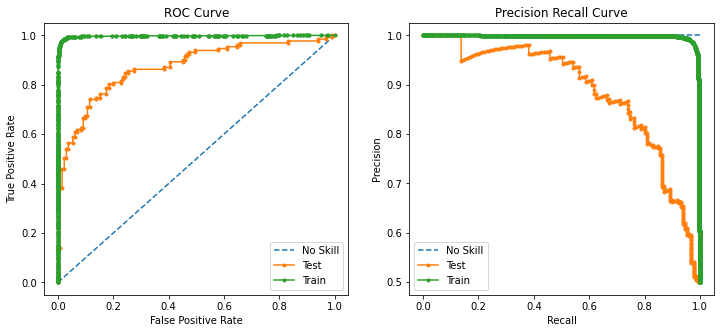

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve


y_predict = predictor.predict_proba(X_ts)
y_predict = y_predict[:,1]
fpr, tpr, thresholds = roc_curve(y_ts, y_predict)#roc curve
precision, recall, thresholds = precision_recall_curve(y_ts, y_predict)#precision recall curve

y_predict2 = predictor.predict_proba(list(X.text))
y_predict2 = y_predict2[:,1]
fpr2, tpr2, thresholds2 = roc_curve(list(y.party), y_predict2)#roc curve
precision2, recall2, thresholds2 = precision_recall_curve(list(y.party), y_predict2)#precision recall curve

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Test')
plt.plot(fpr2, tpr2, marker='.', label='Train')
plt.title('ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot


plt.subplot(1,2,2)
no_skill = len(y[y==1]) / len(y)
plt.plot([1, 0], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Test')
plt.plot(recall2, precision2, marker='.', label='Train')
plt.title('Precision Recall Curve')
# axis lab
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.savefig("BERT.png")